In [2]:
from PPO_train_test import PPO_train, PPO_train_udr, PPO_train_adr, PPO_test

TIMESTEPS = 1_500_000
SEED = 548359

# Hopper Environment

We want to deploy our agent in the real world that is represented by the Target environment, but we have only access to a simulator (source environment) which has a sistematic error wrt real word.

Since we want to close this sim2real gap we will experiment some techniques to address this problem.

To begin with, we will try a simple UDR. Then our focus will be implementing an ADR technique inspired to the OpenAI original paper where ADR is formally introduced in the RL world.

In the following experiment a PPO, policy-based RL algorithm, will be employed.

Nota:
- In Target, l'hopper ha un torso più pesante. La massa elevata conferisce inerzia. L'inerzia agisce come un "filtro passa-basso" naturale: smorza le oscillazioni e rende il robot più stabile contro piccoli errori di controllo o rumore nelle azioni.

- In Source, l'hopper ha un torso molto più leggero. Con meno inerzia, il robot diventa "nervoso" (twitchy). Ogni piccola forza applicata dai motori si traduce in un'accelerazione angolare molto più rapida (F=m⋅a→a=F/m; se m scende, a sale). Questo rende molto più facile per il robot perdere l'equilibrio e cadere (terminando l'episodio prima dei 500 step).

I motori (attuatori) dell'Hopper hanno la stessa forza massima in entrambi gli ambienti, ma nel Source devono spingere meno massa.
Nel caso Source, il robot è "sovra-potenziato" rispetto al suo peso. Questo rende il paesaggio di ottimizzazione (la "superficie" che l'algoritmo PPO deve scalare) molto più frastagliato. Un'azione leggermente sbagliata nel Source porta a conseguenze catastrofiche (caduta) molto più velocemente che nel Target.
L'ambiente Hopper-v* standard di Gym (che corrisponde al tuo Target) è stato progettato e sintonizzato dai creatori di MuJoCo per avere proprietà fisiche che rendono la locomozione apprendibile e stabile. Modificando arbitrariamente una massa fondamentale come quella del torso (togliendo 1kg, che è una percentuale significativa del peso totale), si crea un robot "sbilanciato" o fisicamente meno adatto alla locomozione rispetto al design originale.

Per questo motivo, mentre target->target arriva sempre a 500 timesteps medi (con std=0) per episodio in test, source->source non ci riesce mai.

SOURCE -> SOURCE training:


--- Training on CustomHopper-source-v0 ---


Output()

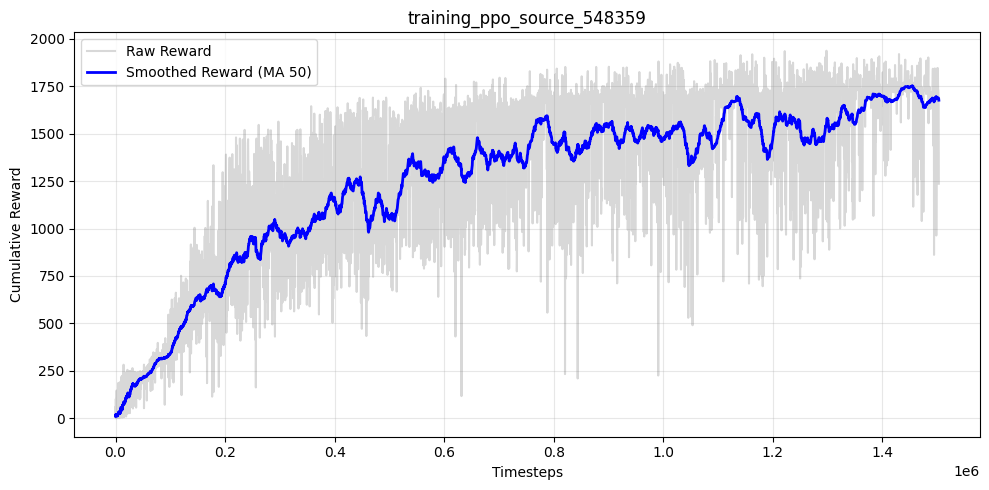

In [2]:
PPO_train(
    train_env_id='CustomHopper-source-v0',
    model_name=f'ppo_source_{SEED}',
    lr=3e-4,
    steps=TIMESTEPS,
    seed=SEED
)

In [3]:
mean, std = PPO_test(
    test_env_id='CustomHopper-source-v0',
    model_name=f'ppo_source_{SEED}'
)

--- Testing on CustomHopper-source-v0 ---


/opt/miniconda3/envs/rl_project/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Test Results:
  Mean Reward: 1733.35 +/- 15.40
  Mean Steps:  500.00 +/- 0.00


Now, lets test it on target:

In [4]:
mean, std = PPO_test(
    test_env_id='CustomHopper-target-v0',
    model_name=f'ppo_source_{SEED}'
)

--- Testing on CustomHopper-target-v0 ---
Test Results:
  Mean Reward: 752.90 +/- 4.22
  Mean Steps:  209.00 +/- 1.20


TARGET -> TARGET training:

Output()


--- Training on CustomHopper-target-v0 ---


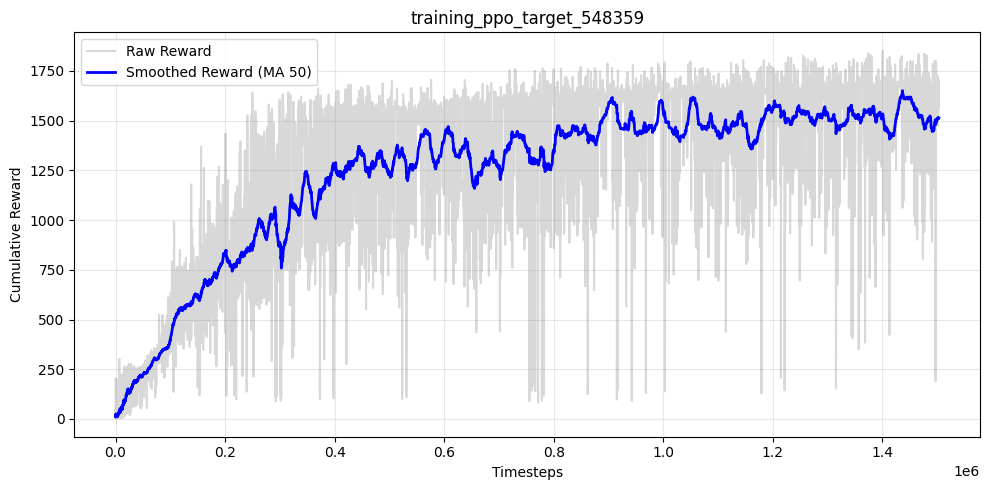

In [5]:
PPO_train(
    train_env_id='CustomHopper-target-v0',
    model_name=f'ppo_target_{SEED}',
    lr=3e-4,
    steps=TIMESTEPS,
    seed=SEED
)

In [6]:
mean, std = PPO_test(
    test_env_id='CustomHopper-target-v0',
    model_name=f'ppo_target_{SEED}'
)

--- Testing on CustomHopper-target-v0 ---


/opt/miniconda3/envs/rl_project/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Test Results:
  Mean Reward: 1700.31 +/- 13.22
  Mean Steps:  500.00 +/- 0.00


## UDR

Output()


--- Training on CustomHopper-source-v0 using UDR ---


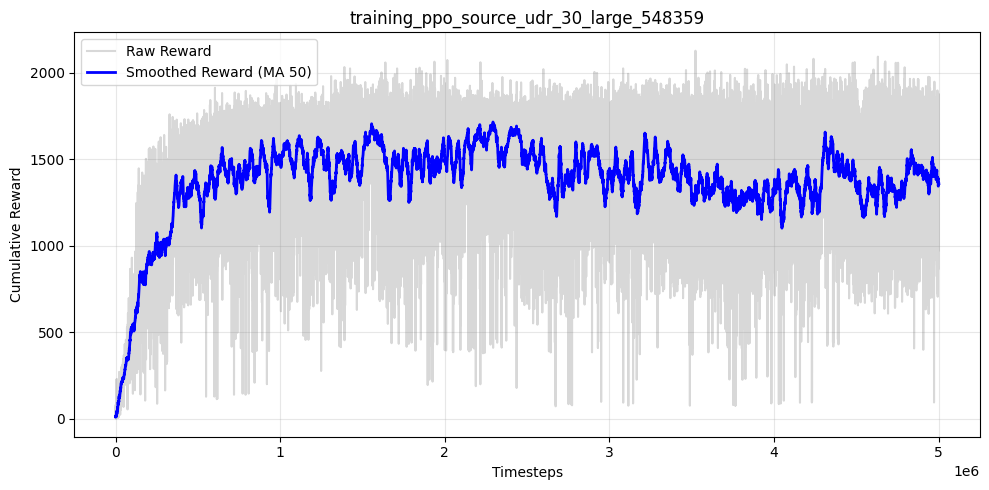

In [ ]:
PPO_train_udr(
    train_env_id='CustomHopper-source-v0',
    model_name=f'ppo_source_udr_20_large_{SEED}',
    lr=3e-4,
    lr_scheduler_type='constant',
    steps=TIMESTEPS,
    udr_range=0.2,
    net_size="large", # [ small - medium - large ] -> [ 64 - 128 - 256 ],
    seed=SEED
)

In [6]:
mean, std = PPO_test(
    test_env_id='CustomHopper-target-v0',
    model_name=f'ppo_source_udr_30_large_{SEED}'
)

--- Testing on CustomHopper-target-v0 ---


/opt/miniconda3/envs/rl_project/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Test Results:
  Mean Reward: 881.98 +/- 21.75
  Mean Steps:  228.66 +/- 4.79


## ADR (OpenAI Style)

In [ ]:
PPO_train_adr(
    train_env_id='CustomHopper-source-v0',
    model_name=f'ppo_source_adr_30_large_{SEED}',
    lr=3e-4,
    lr_scheduler_type="constant",
    steps=TIMESTEPS,
    starting_adr_range=0.05,
    objective_adr_range=0.4,
    increase_rate=0.05,
    reward_to_check=1300,
    check_frequency=40_000,
    net_size="large",
    seed=SEED
)

In [ ]:
mean, std = PPO_test(
    test_env_id='CustomHopper-target-v0',
    model_name=f'ppo_source_adr_30_large_{SEED}'
)

## Agent Visualization

In [ ]:
from utils.visualize_agent import visualize

model = f"ppo_source_adr_30_medium_{SEED}"

visualize(
    model_path=f"models/{model}",
    env_id="CustomHopper-target-v0"
)